In [1]:
import pdb

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import radvel

import rvsearch
from rvsearch import utils

%matplotlib inline

# Compile Specmatch (hybrid of synth. and emp.) parameters for the Legacy sample.

## Take specmatch-synth data, use for all appropriate stars. Take specmatch-emp data, use for Teff < 4700. Also load legacy starlist.

In [2]:
#legacy = pd.read_csv('legacy_starlist.csv')
#legacy_names = list(legacy['name'])
legacy = pd.read_csv('../legacy_906_starlist.txt')
legacy_names = list(legacy['Name'])
legacy_names = [legacy_names[i].lower() for i in np.arange(len(legacy_names))]

# Make specmatch names lowercase, to match the legacy target list file.
specmatch_synth = pd.read_csv('specmatch_results_synth_new.csv')
specmatch_synth['name'] = specmatch_synth['name'].str.lower()
specmatch_s_names = specmatch_synth.name.unique()

specmatch_emp = pd.read_csv('specmatch_results_emp_new.csv')
specmatch_emp['name'] = specmatch_emp['name'].str.lower()
specmatch_e_names = specmatch_emp.name.unique()

In [3]:
legacy_names

['0748-01711-1',
 '10002',
 '10008',
 '100180',
 '100623',
 '101259',
 '10145',
 '101501',
 '102195',
 '103095',
 '103932',
 '104067',
 '104304',
 '104556',
 '10476',
 '104800',
 '105113',
 '105631',
 '106116',
 '106156',
 '10697',
 '10700',
 '107148',
 '10780',
 '10790',
 '10853',
 '108874',
 '109358',
 '110315',
 '110463',
 '110537',
 '110897',
 '111031',
 '111395',
 '111515',
 '111631',
 '112257',
 '112914',
 '114174',
 '114613',
 '114729',
 '114762',
 '114783',
 '114946',
 '115404a',
 '115617',
 '116321',
 '116442',
 '116443',
 '116956',
 '117176',
 '117207',
 '117936',
 '118096',
 '11964a',
 '119802',
 '119850',
 '120066',
 '120136',
 '120467',
 '12051',
 '122064',
 '122120',
 '122303',
 '122652',
 '124106',
 '124292',
 '124642',
 '125184',
 '125455',
 '126053',
 '12661',
 '126614',
 '127334',
 '127506',
 '128165',
 '128311',
 '12846',
 '130004',
 '130307',
 '130322',
 '13043',
 '130992',
 '131156',
 '132142',
 '132505',
 '1326',
 '1326b',
 '134987',
 '135101a',
 '13612b',
 '13635

## Save all specmatch/isoclassify properties for legacy stars. Take median values. 

In [4]:
specmatch_synth.columns

Index(['Unnamed: 0', 'id', 'name', 'obs', 'obstime', 'run', 'runnum', 'expnum',
       'outdir', 'outdir_mtime', 'teff', 'teff_err', 'teff_seg_std',
       'teff_uncal', 'logg', 'logg_err', 'logg_seg_std', 'logg_uncal', 'fe',
       'fe_err', 'fe_seg_std', 'fe_uncal', 'vsini', 'vsini_err',
       'vsini_seg_std', 'kmag', 'kmag_err', 'rchisq1', 'rchisq0', 'psf',
       'delta', 'seg_count', 'iso_mass', 'iso_mass_err1', 'iso_mass_err2',
       'iso_radius', 'iso_radius_err1', 'iso_radius_err2', 'iso_logage',
       'iso_logage_err1', 'iso_logage_err2', 'iso_age', 'iso_age_err1',
       'iso_age_err2', 'iso_teff', 'iso_teff_err1', 'iso_teff_err2',
       'iso_logg', 'iso_logg_err1', 'iso_logg_err2', 'iso_fe', 'iso_fe_err1',
       'iso_fe_err2', 'iso_parallax', 'iso_parallax_err1',
       'iso_parallax_err2'],
      dtype='object')

In [5]:
specmatch_emp.columns

Index(['Unnamed: 0', 'id', 'name', 'obs', 'obstime', 'run', 'runnum', 'expnum',
       'outdir', 'outdir_mtime', 'teff', 'teff_err', 'radius', 'radius_err',
       'fe', 'fe_err', 'iso_mass', 'iso_mass_err1', 'iso_mass_err2',
       'iso_radius', 'iso_radius_err1', 'iso_radius_err2', 'iso_logage',
       'iso_logage_err1', 'iso_logage_err2', 'iso_teff', 'iso_teff_err1',
       'iso_teff_err2', 'iso_logg', 'iso_logg_err1', 'iso_logg_err2', 'iso_fe',
       'iso_fe_err1', 'iso_fe_err2'],
      dtype='object')

In [6]:
intersection = list(set(specmatch_synth.columns) & set(specmatch_emp.columns))
print(intersection)

['iso_teff', 'run', 'iso_logage_err2', 'iso_radius', 'iso_fe_err1', 'fe', 'iso_mass_err1', 'iso_radius_err1', 'iso_mass', 'iso_teff_err1', 'iso_logg_err2', 'teff_err', 'iso_logage', 'name', 'iso_logage_err1', 'obs', 'iso_logg_err1', 'outdir_mtime', 'teff', 'fe_err', 'iso_fe_err2', 'iso_mass_err2', 'iso_teff_err2', 'iso_fe', 'outdir', 'Unnamed: 0', 'expnum', 'iso_logg', 'obstime', 'iso_radius_err2', 'runnum', 'id']


## Specmatch-emp does not produce vsini, and only returns iso_ labels for some parameters.

In [7]:
select_synth_columns = ['obs','name', 'teff', 'teff_err', 'logg', 
                        'logg_err', 'fe', 'fe_err', 'vsini', 'vsini_err',
                        'iso_mass', 'iso_mass_err1', 'iso_mass_err2',
                        'iso_radius', 'iso_radius_err1', 'iso_radius_err2', 
                        'iso_logage', 'iso_logage_err1', 'iso_logage_err2', 
                        'iso_age', 'iso_age_err1', 'iso_age_err2', 
                        'iso_teff', 'iso_teff_err1', 'iso_teff_err2',
                        'iso_logg', 'iso_logg_err1', 'iso_logg_err2', 
                        'iso_fe', 'iso_fe_err1', 'iso_fe_err2']

select_emp_columns   = ['obs','name', 'teff', 'teff_err', 
                        'radius', 'radius_err', 'fe', 'fe_err']

In [8]:
specmatch_synth = specmatch_synth[select_synth_columns]
specmatch_emp = specmatch_emp[select_emp_columns]
len(select_emp_columns)

8

## Merge synthetic and empirical tables.

In [9]:
smsyn = specmatch_synth.copy()
smemp = specmatch_emp.copy()

# As of 7/29, add four dummy rows, for the four stars that don't have emp results.
smemp.loc[smemp.shape[0]] = ['rj169.108', '134439', 5700, 100, 1, 0.05, 0, 0.05]
smemp.loc[smemp.shape[0]] = ['rj169.109', '134440', 5700, 100, 1, 0.05, 0, 0.05]
smemp.loc[smemp.shape[0]] = ['rdummydum', '168723', 5700, 100, 1, 0.05, 0, 0.05]
smemp.loc[smemp.shape[0]] = ['rj238.334', 'hip106924', 5700, 100, 1, 0.05, 0, 0.05]
# 168723 is also missing Syn results, since it doesn't have a Keck template.
#smsyn.loc[smsyn.shape[0]] = ['rdummydum', '168723', 5700, 100, 1, 0.05, 0, 0.05, 1, 0.1,
#                             1, 0.05, 0.05, 1, 0.05, 0.05, 0, 0.05, 0.05, 1,
#                             0.05, 0.05, 5700, 100, 100, 0, 0.05, 0.05, 0, 0.05, 0.05]

smemp.columns = smemp.columns.map(lambda x: str(x) + '_emp')

merge = smsyn.merge(smemp, left_on='obs', right_on='obs_emp')
# Remove superfluous name columns.
merge = merge.drop(columns=['name_emp'])
merge = merge.dropna(axis='columns', how='all')


In [10]:
merge.columns

Index(['obs', 'name', 'teff', 'teff_err', 'logg', 'logg_err', 'fe', 'fe_err',
       'vsini', 'iso_mass', 'iso_mass_err1', 'iso_mass_err2', 'iso_radius',
       'iso_radius_err1', 'iso_radius_err2', 'iso_logage', 'iso_logage_err1',
       'iso_logage_err2', 'iso_age_err1', 'iso_age_err2', 'iso_teff',
       'iso_teff_err1', 'iso_teff_err2', 'iso_logg', 'iso_logg_err1',
       'iso_logg_err2', 'iso_fe', 'iso_fe_err1', 'iso_fe_err2', 'obs_emp',
       'teff_emp', 'teff_err_emp', 'radius_emp', 'radius_err_emp', 'fe_emp',
       'fe_err_emp'],
      dtype='object')

## Drop all non-legacy stars.

In [11]:
merge_legacy = merge[merge['name'].isin(legacy_names)]
print('Whole legacy sample:', len(merge_legacy.name.unique()))
bastards = np.setdiff1d(legacy_names, merge_legacy.name.unique())
print('Bastards:', bastards)
#merge_legacy.name.unique()

Whole legacy sample: 745
Bastards: ['168723']


In [12]:
#merge.loc[merge.name == '134439']['iso_mass']
merge_legacy['iso_mass']
nandex = np.argwhere(np.isnan(merge_legacy.iso_mass))[:,0]
merge_legacy.loc[nandex]

,obs,name,teff,teff_err,logg,logg_err,fe,fe_err,vsini,iso_mass,...,iso_fe,iso_fe_err1,iso_fe_err2,obs_emp,teff_emp,teff_err_emp,radius_emp,radius_err_emp,fe_emp,fe_err_emp
97,rj06.1068,50692,5793.040455,100.0,4.274647,0.1,-0.168848,0.06,4.157688e-07,0.901748,...,-0.186709,0.061801,-0.058913,rj06.1068,5748.0,110.0,1.069,0.18,-0.24,0.09
378,rj13.2196,40397,5474.361600,100.0,4.291033,0.1,-0.057845,0.06,1.548670e-07,0.870956,...,-0.065872,0.059761,-0.062183,rj13.2196,5468.0,110.0,1.016,0.18,-0.09,0.09
560,rj20.1315,98281,5404.260298,100.0,4.548887,0.1,-0.144263,0.06,1.468365e+00,0.832463,...,-0.170275,0.061099,-0.062298,rj20.1315,5388.0,110.0,0.873,0.10,-0.28,0.09
1391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1554,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1643,rj70.466,143761,5728.993547,100.0,4.135210,0.1,-0.189674,0.06,5.468818e-07,0.899152,...,-0.200675,0.059014,-0.059278,rj70.466,5676.0,110.0,1.172,0.18,-0.30,0.09
1779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Make unique, median dataframe for stellar parameters. Save.

In [13]:
specmatch_legacy = merge_legacy.groupby('name', as_index=False).median()

In [14]:
specmatch_legacy[['name', 'iso_mass', 'teff_emp', 'fe', 'fe_emp', 'fe_err']].sort_values(by='iso_mass')

,name,iso_mass,teff_emp,fe,fe_emp,fe_err
408,25329,0.507721,5695.0,-1.575816,-0.490,0.06
720,hip70865,0.516160,3579.0,-1.032447,0.030,0.06
653,gl514,0.518189,3674.0,-0.948367,-0.200,0.06
698,hip428,0.518616,3680.0,-0.949649,-0.090,0.06
703,hip51007,0.522035,3682.0,-0.925429,-0.010,0.06
357,217987,0.533508,3677.0,-0.917005,-0.235,0.06
667,gl87,0.536727,3627.5,-0.907207,-0.445,0.06
728,hip83043,0.537239,3628.0,-0.856979,-0.065,0.06
652,gl49,0.537349,3670.0,-0.900448,0.110,0.06
632,gl239,0.541076,3779.0,-0.863073,-0.420,0.06


In [15]:
specmatch_legacy.to_csv('legacy_specmatch_medians.csv')

In [16]:
len(specmatch_legacy)

745

## Clean house.

In [17]:
spec_syn = specmatch_legacy.query('teff_emp > 4700')
spec_emp = specmatch_legacy.query('teff_emp <= 4700')

In [18]:
print(len(spec_syn), len(spec_emp))

556 189


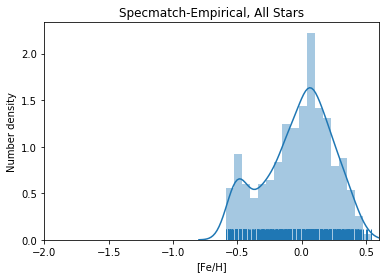

In [19]:
ax = sns.distplot(specmatch_legacy['fe_emp'], bins=18, rug=True)
ax.set(xlabel='[Fe/H]', ylabel='Number density')
ax.set_title('Specmatch-Empirical, All Stars')
ax.set_xlim([-2, 0.6])

fig = ax.get_figure()
fig.savefig('specmatch_metallicity_histogram_emp_all.pdf')

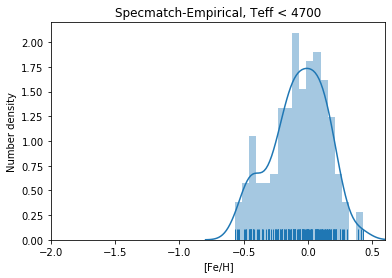

In [20]:
ax = sns.distplot(spec_emp['fe_emp'], bins=18, rug=True)
ax.set(xlabel='[Fe/H]', ylabel='Number density')
ax.set_title('Specmatch-Empirical, Teff < 4700')
ax.set_xlim([-2, 0.6])

fig = ax.get_figure()
fig.savefig('specmatch_metallicity_histogram_emp.pdf')

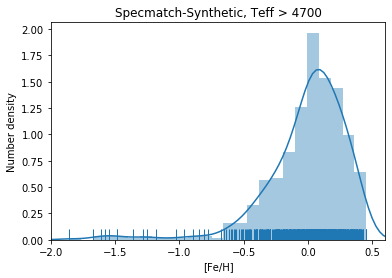

In [21]:
#[~np.isnan(spec_syn['fe'])]
ax = sns.distplot(spec_syn['fe'], bins=25, rug=True)
ax.set(xlabel='[Fe/H]', ylabel='Number density')
ax.set_title('Specmatch-Synthetic, Teff > 4700')
ax.set_xlim([-2, 0.6])

fig = ax.get_figure()
fig.savefig('specmatch_metallicity_histogram_synthetic.pdf')

ValueError: array must not contain infs or NaNs

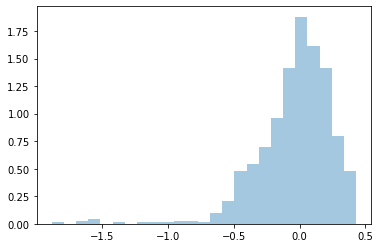

In [22]:
fe_all = spec_syn['iso_fe'].tolist() + spec_emp['fe_emp'].tolist()
#[~np.isnan(fe_all)]
ax = sns.distplot(fe_all, bins=25, rug=True)
ax.set(xlabel='[Fe/H]', ylabel='Number density')
ax.set_title('Specmatch Emp & Syn, bound Teff = 4700')
ax.set_xlim([-2, 0.6])

fig = ax.get_figure()
fig.savefig('specmatch_metallicity_histogram_all.pdf')

In [126]:
low_metals = specmatch_legacy.loc[specmatch_legacy.fe < -0.6]
len(low_metals)

129

In [127]:
low_metals[['name', 'fe', 'iso_mass']]
#low_metals[np.isnan(low_metals['iso_mass'])]
#low_metals.loc[low_metals.type=='emp']

,name,fe,iso_mass
5,101259,-0.650287,0.903295
19,104800,-0.678264,0.762383
49,114762,-0.638020,0.781896
66,119850,-0.860407,0.567113
75,122303,-0.805588,0.579293
104,1326,-0.803214,0.601743
105,1326b,-0.746541,0.648751
150,147379b,-1.001291,0.584672
209,165222,-0.845757,0.564814
235,173739,-0.965543,0.589445


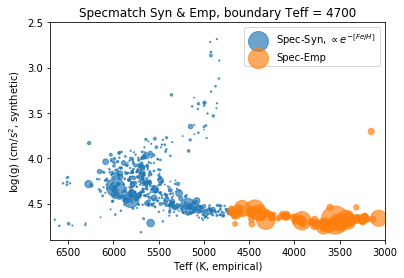

In [128]:
fig, ax = plt.subplots()

ax.scatter(spec_syn['teff_emp'], spec_syn['iso_logg'], 
           alpha=0.66, s=3*np.exp(-3*specmatch_legacy['fe']),
           label='Spec-Syn, $\propto e^{-[Fe/H]}$')

ax.set_title('Specmatch Syn & Emp, boundary Teff = 4700')
ax.scatter(spec_emp['teff_emp'], spec_emp['iso_logg'], 
           s=3*np.exp(-3*cut['fe']), 
           alpha=0.66, label='Spec-Emp')
ax.set_xlabel('Teff (K, empirical)')
ax.set_ylabel('log(g) (cm/s$^2$, synthetic)')
ax.set_ylim([4.9, 2.5])
ax.set_xlim([6700, 3000])
ax.legend()

#print(cut['name teff logg fe vsini'.split()])
fig.savefig('main_sequence_all.pdf')

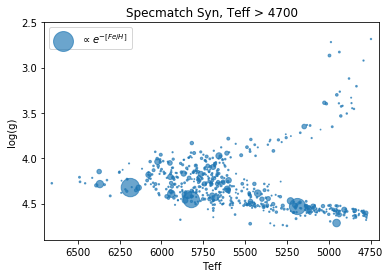

In [129]:
fig, ax = plt.subplots()

ax.scatter(spec_syn['teff'], spec_syn['iso_logg'], 
           alpha=0.66, s=3*np.exp(-3*specmatch_legacy['fe']),
           label='$\propto e^{-[Fe/H]}$')

ax.set_title('Specmatch Syn, Teff > 4700')
#ax.scatter(spec_emp['teff_emp'], spec_emp['iso_logg'], s=np.exp(-3*cut['fe']), 
#           alpha=0.66, label='Specmatch-Emp')
ax.set_xlabel('Teff')
ax.set_ylabel('log(g)')
ax.set_ylim([4.9, 2.5])
ax.set_xlim([6700, 4700])
ax.legend()

#print(cut['name teff logg fe vsini'.split()])
fig.savefig('main_sequence_syn.pdf')

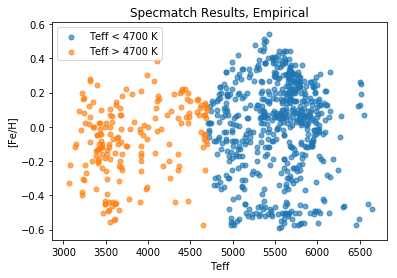

In [134]:
fig, ax = plt.subplots()

ax.scatter(spec_syn['teff_emp'], spec_syn['fe_emp'], 
           alpha=0.66, label='Teff <= 4700 K')
#s=np.exp(-3*synth['fe']),
ax.scatter(spec_emp['teff_emp'], spec_emp['fe_emp'], 
           alpha=0.66, label='Teff > 4700 K')

ax.set_title('Specmatch Results, Empirical')
ax.set_xlabel('Teff')
ax.set_ylabel('[Fe/H]')
#ax.set_ylim([4.9, 2.5])
ax.legend()

#print(cut['name teff logg fe vsini'.split()])
fig.savefig('specmatch_divide_all_emp.pdf')

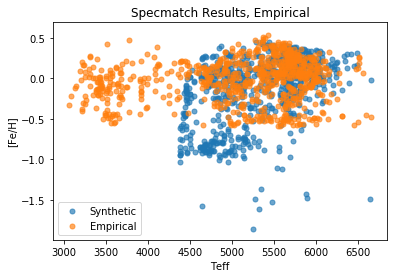

In [146]:
fig, ax = plt.subplots()

ax.scatter(specmatch_legacy['teff'], specmatch_legacy['fe'], 
           alpha=0.66, label='Synthetic')
#s=np.exp(-3*synth['fe']),
ax.scatter(specmatch_legacy['teff_emp'], specmatch_legacy['fe_emp'], 
           alpha=0.66, label='Empirical')

ax.set_title('Specmatch Results, Empirical')
ax.set_xlabel('Teff')
ax.set_ylabel('[Fe/H]')
#ax.set_ylim([4.9, 2.5])
ax.legend()

#print(cut['name teff logg fe vsini'.split()])
fig.savefig('specmatch_divide_diff.pdf')

## Find the stars that are hotter than 4700 K and have significantly different Syn/Emp results .

## Use difference of 1-sigma first, whichever error is smaller (synth).

In [161]:
diff = np.absolute(specmatch_legacy.fe - specmatch_legacy.fe_emp)
suspicious_1 = specmatch_legacy.query('@diff > fe_err and teff_emp > 4700')

In [162]:
len(suspicious_1)

192

In [168]:
diff_teff = [suspicious_1['teff'], suspicious_1['teff_emp']]
diff_fe   = [suspicious_1['fe'], suspicious_1['fe_emp']]

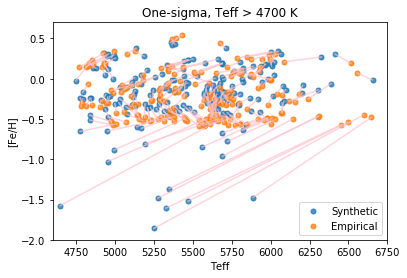

In [188]:
fig, ax = plt.subplots()

ax.plot(diff_teff, diff_fe, c='pink', alpha=0.66)
ax.scatter(suspicious_1['teff'], suspicious_1['fe'], 
           alpha=0.8, label='Synthetic')
ax.scatter(suspicious_1['teff_emp'], suspicious_1['fe_emp'], 
           alpha=0.8, label='Empirical')

ax.set_title('One-sigma, Teff > 4700 K')
ax.set_xlabel('Teff')
ax.set_ylabel('[Fe/H]')
ax.set_xlim([4600, 6750])
ax.set_ylim([-2, 0.7])
ax.legend()

#print(cut['name teff logg fe vsini'.split()])
fig.savefig('specmatch_suspicious_diff_1.pdf')

## Too broad. Let's use a 3-sigma cut.

In [180]:
suspicious_3 = specmatch_legacy.query('@diff > 3*fe_err and teff_emp > 4700').reset_index()
len(suspicious_3)

29

In [191]:
suspicious_3[['name', 'vsini', 'teff', 'teff_emp', 'fe', 'fe_emp', 'fe_err', 'fe_err_emp']]

,name,vsini,teff,teff_emp,fe,fe_emp,fe_err,fe_err_emp
0,136352,1.363507e+00,5652.518786,5611.0,-0.260514,-0.510,0.06,0.09
1,136925,2.164483e-06,5652.950765,5647.0,-0.231090,-0.450,0.06,0.09
2,150433,4.193689e-07,5591.149756,5636.0,-0.298446,-0.500,0.06,0.09
3,157214,2.652227e-07,5617.084806,5650.0,-0.319763,-0.510,0.06,0.09
4,165401,7.870893e-07,5795.524189,5727.0,-0.324675,-0.570,0.06,0.09
5,170174,4.184085e+00,4987.126031,4929.0,0.000478,0.190,0.06,0.09
6,188510,2.490748e-08,5274.702941,6310.0,-1.483160,-0.460,0.06,0.09
7,19034,1.552343e-07,5412.876273,5542.0,-0.396489,-0.590,0.06,0.09
8,193901,4.436639e-07,5689.876179,6142.0,-0.964251,-0.500,0.06,0.09
9,199476,1.801494e+00,5439.156673,5539.0,-0.329628,-0.510,0.06,0.09


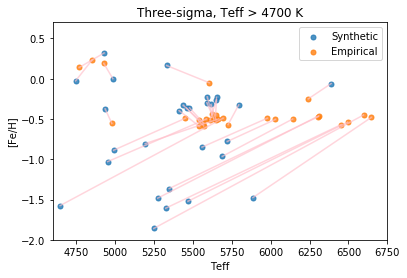

In [189]:
fig, ax = plt.subplots()

diff_teff_3 = [suspicious_3['teff'], suspicious_3['teff_emp']]
diff_fe_3   = [suspicious_3['fe'], suspicious_3['fe_emp']]

ax.plot(diff_teff_3, diff_fe_3, c='pink', alpha=0.66)
ax.scatter(suspicious_3['teff'], suspicious_3['fe'], 
           alpha=0.8, label='Synthetic')
ax.scatter(suspicious_3['teff_emp'], suspicious_3['fe_emp'], 
           alpha=0.8, label='Empirical')

ax.set_title('Three-sigma, Teff > 4700 K')
ax.set_xlabel('Teff')
ax.set_ylabel('[Fe/H]')
ax.set_xlim([4600, 6750])
ax.set_ylim([-2, 0.7])
ax.legend()

#print(cut['name teff logg fe vsini'.split()])
fig.savefig('specmatch_suspicious_diff_3.pdf')

In [193]:
spec_emp.name

4         101206
12        103932
15         10436
30         10853
35        110315
43        111631
62        118096
65        119802
66        119850
69        120467
70       120476a
73        122064
74        122120
75        122303
79        124642
87        127506
104         1326
105        1326b
121       139477
149      147379a
150      147379b
152       148467
161       151288
165       151995
174       154363
177       156026
189       157881
197        16160
209       165222
224       170493
         ...    
737     hip51007
739     hip53020
740     hip54532
741     hip55360
742      hip5643
743     hip57050
744     hip57087
746     hip57548
747    hip59406b
748     hip60559
749     hip60633
750     hip63510
751     hip66459
752     hip67164
753     hip70865
754     hip70975
755     hip71253
756     hip71898
757     hip74995
759      hip8051
760     hip80824
761     hip83043
762     hip84099
763     hip84790
764     hip86961
769     hip91699
770     hip92403
772       lhs4